## 0: Loading Dependencies

In [13]:
#
# Import the necessary modules
#

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

import scipy.stats as stats
import matplotlib.dates as mdates
from datetime import datetime

import calendar
from scipy.stats import f_oneway


import warnings

import GooseUtils

# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [14]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 1 data from the relevant CSV file
grp1_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_01.csv')
grp2_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_02.csv', on_bad_lines='skip')
grp3_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_03.csv')


# Filter out irrelevant columns from the dataframes
relevant_cols = ['BAND', 
                 'ORIGINAL_BAND', 
                 'OTHER_BANDS', 
                 'EVENT_DATE', 
                 'EVENT_DAY', 
                 'EVENT_MONTH', 
                 'EVENT_YEAR', 
                 'LAT_DD', 
                 'LON_DD', 
                 'COORD_PREC',
                 'SPECIES_ID',]

grp1_goose_data_raw = grp1_goose_data_raw[relevant_cols]
grp2_goose_data_raw = grp2_goose_data_raw[relevant_cols]
grp3_goose_data_raw = grp3_goose_data_raw[relevant_cols]

In [15]:
# Retrieve dataframes for each species
white_fronted_goose_data_raw = (grp1_goose_data_raw[(grp1_goose_data_raw['SPECIES_ID'] == 1710) | \
                                                   (grp1_goose_data_raw['SPECIES_ID'] == 1719)]).drop(labels='SPECIES_ID', axis=1)
snow_goose_data_raw = (grp1_goose_data_raw[(grp1_goose_data_raw['SPECIES_ID'] == 1690) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1699) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1691) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1698)]).drop(labels='SPECIES_ID', axis=1)
cackling_goose_data_raw = (grp3_goose_data_raw[(grp3_goose_data_raw['SPECIES_ID'] == 1721) | \
                                             (grp3_goose_data_raw['SPECIES_ID'] == 1722)]).drop(labels='SPECIES_ID', axis=1)

cg_grp3_data = grp3_goose_data_raw[(grp3_goose_data_raw['SPECIES_ID'] == 1729) | \
                                   (grp3_goose_data_raw['SPECIES_ID'] == 1723)]
canada_goose_data_raw = pd.concat([grp2_goose_data_raw, cg_grp3_data], ignore_index=True)

## 1: Data Cleaning

Here all irrelevant entries in the data are filtered out and the data is formatted for use.

### 1.1: Formatting Date

A large number of the date cells (~ $3,295$) do not work with the `pd.to_datetime()` function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

1. If the `'EVENT_DATE'` column already has a valid date that works with `pd.to_datetime()`, it will be the date used.
2. Otherwise, if the `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` column all form a date that works with `pd.to_datetime()`, it will be the date used.
3. If neither of the above work, `NaT` will be assigned and the row will be dropped.


The `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` columns are all updated with the relevant information (will be used for grouping later).

In [16]:
#
# Clean the datetime columns
#

# Perfomes datetime cleaning
def clean_datetime(goose_data):
    goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

    # Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns BEFORE DROPPING THEM
    dates_from_columns = pd.to_datetime(
        goose_data['EVENT_MONTH'].astype(str) + '/' +
        goose_data['EVENT_DAY'].astype(str) + '/' +
        goose_data['EVENT_YEAR'].astype(str),
        format='%m/%d/%Y',
        errors='coerce'
    )

    # Fill in all NaT values that can be filled with the guesses from the previous line.
    goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

    # Remove all rows where EVENT_DATE is still NaT after the above operations.
    goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

    # drop EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns
    #goose_data = goose_data.drop(labels=['EVENT_MONTH', 'EVENT_DAY', 'EVENT_YEAR'], axis=1)

    return goose_data

white_fronted_goose_data = clean_datetime(white_fronted_goose_data_raw)
snow_goose_data = clean_datetime(snow_goose_data_raw)
cackling_goose_data = clean_datetime(cackling_goose_data_raw)
canada_goose_data = clean_datetime(canada_goose_data_raw)

### 1.2: Formatting Coordinates and Deriving a Coordinate Uncertainy

Location data is also vital for analysis, so abit of cleaning will have to be done.

First, rows fitting any of the following conditions will be excluded:
1. Rows that do not have values for either `LAT_DD` or `LON_DD` because this issue cannot be rectified.
2. Rows whose `COORD_PREC` values are `8`, `12`, `18`, `28`, `33`, `38`, `72`, or `NaN` because an uncertainty given either cannot be determined or is too big to be useful (Corresponds to $\sim 1015$ entries).

In [17]:
#
# Clean the coordinates columns as described above.
#

# Perform location cleaning
def clean_location(goose_data):
    # Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
    goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

    # Filter out all rows with unusable or useless coordinate precision values as outlined above.
    goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                              (goose_data['COORD_PREC'] == 12) | \
                              (goose_data['COORD_PREC'] == 18) | \
                              (goose_data['COORD_PREC'] == 28) | \
                              (goose_data['COORD_PREC'] == 33) | \
                              (goose_data['COORD_PREC'] == 38) | \
                              (goose_data['COORD_PREC'] == 72) | \
                              (goose_data['COORD_PREC'].isna()))]

    goose_data = goose_data[(goose_data['LAT_DD'] != 0.0) | (goose_data['LON_DD'] != 0.0)]

    return goose_data

white_fronted_goose_data = clean_location(white_fronted_goose_data)
snow_goose_data = clean_location(snow_goose_data)
cackling_goose_data = clean_location(cackling_goose_data)
canada_goose_data = clean_location(canada_goose_data)

Additionally, a new column with lattitude and longitude uncertainties will be made whose values obey the following rules:
1. If the `COORD_PREC` corresponds to an exact location (is `0`), then the uncertainty is $5*10^{6}$ to account for limits in the number of significant digits given by the data.
2. If the `COORD_PREC` corresponds to a 1-minute block (is `1`), then the uncertainty is $\frac{1}{120} \approx 0.01$ degrees (rounded up) since the coordinates are in the centroid of the block.
3. If the `COORD_PREC` corresponds to a 10-minute block (is `10`), then the uncertainty is $\frac{1}{12} \approx 0.1$ degrees (rounded up) since the coordinates are in the centroid of the block.
4. If the `COORD_PREC` corresponds to a 1-degree block (is `60`), then the uncertainty is $0.5$ degrees since the coordinates are in the centroid of the block.
5. If the `COORD_PREC` corresponds to a county (is `7`), then the uncertainty will be $0.25$ degrees by estimate (since the average county land area is 1090.69 degrees and a sqaure of that size is around $0.5$ degrees in lattitude and longitude)
6. If the `COORD_PREC` corresponds to a town/area (is `11`), then the uncertainty will be $0.25$ degrees by estimate (since each town should be smaller than a county and thus have less uncertainty associated with it)

In [18]:
#
# Perform the coordinate precision conversion as described above.
#

def convert_coord_precision(goose_data):
    # Compute coording uncertainties
    goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_unc(x))

    # Drop the old column
    goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

    return goose_data

white_fronted_goose_data = convert_coord_precision(white_fronted_goose_data)
snow_goose_data = convert_coord_precision(snow_goose_data) 
cackling_goose_data = convert_coord_precision(cackling_goose_data)
canada_goose_data = convert_coord_precision(canada_goose_data)

## 2: Perliminary Analysis

### 2.1: Question 1: Does the White Fronted Goose Move Over the Course of a Year?

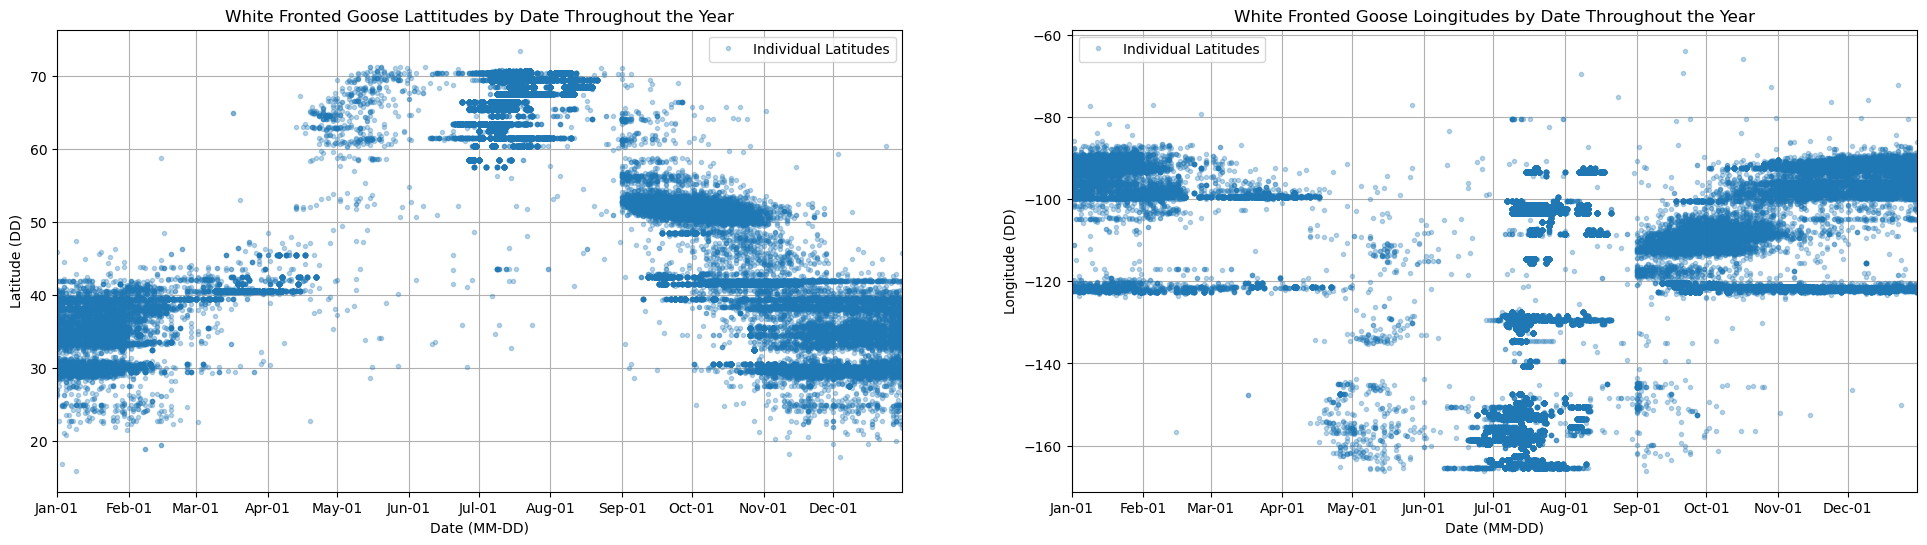

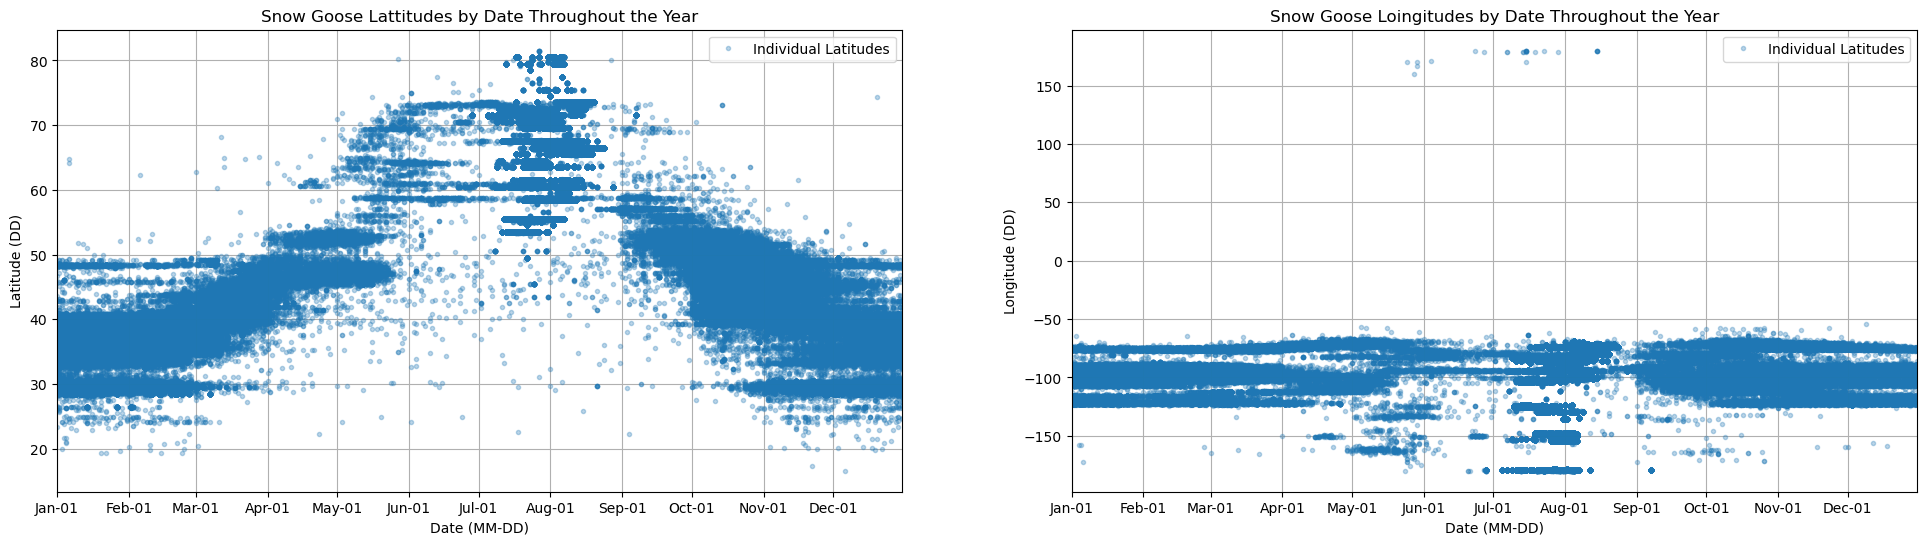

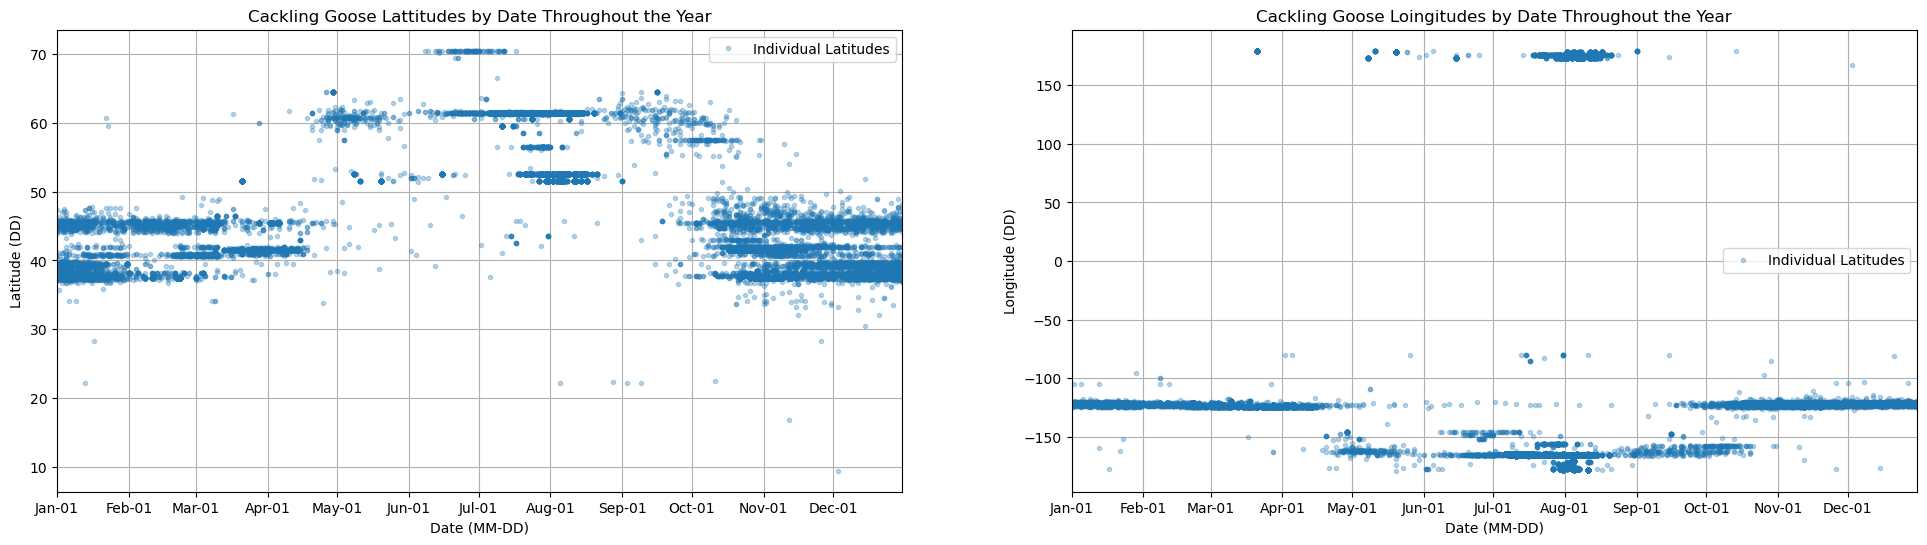

c:\Users\wagn5\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


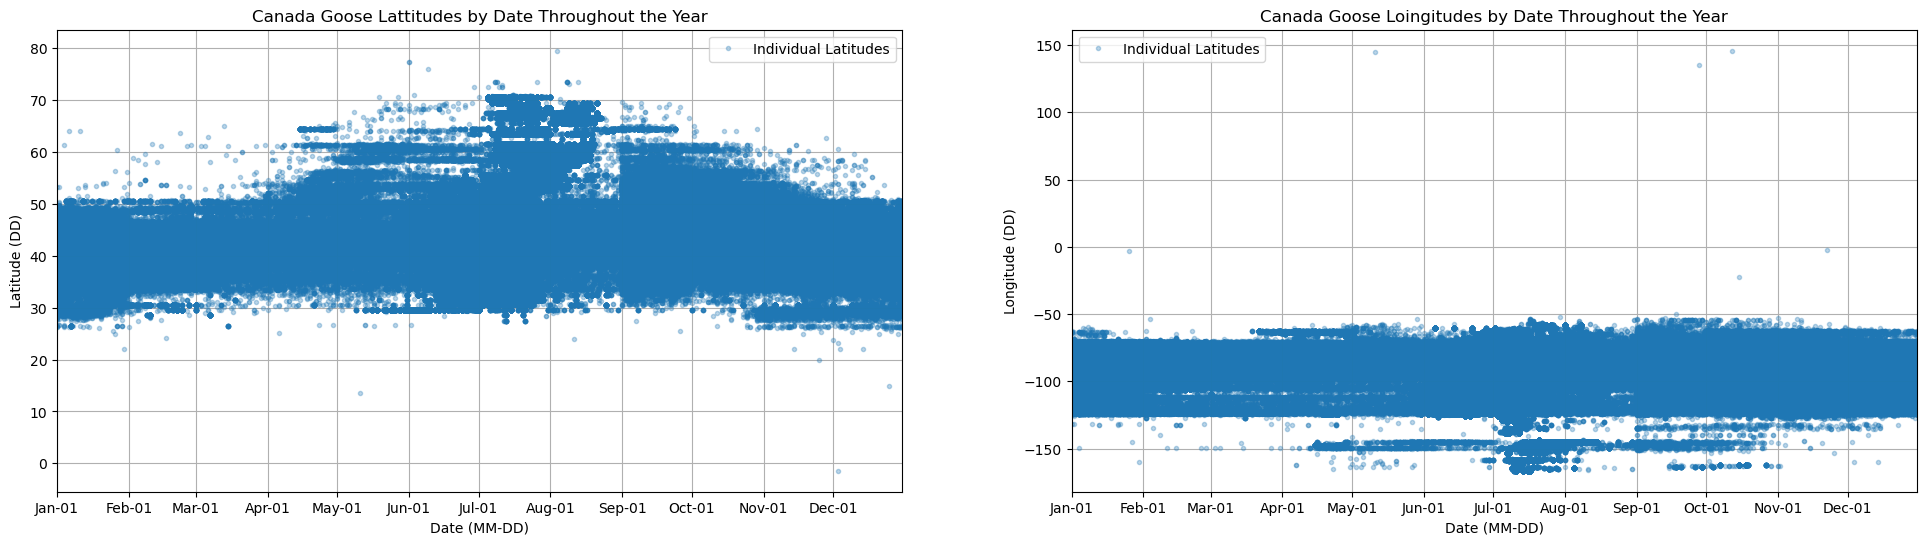

In [19]:
#
# Plot the latitudes and longitudes by date throughout the year
#

def scatter_data(goose_data, goose_name = ''):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 6))
    fmt = mdates.DateFormatter("%b-%d")

    #
    # Plot lattitudes by date excluding the year.
    #
    ax1.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LAT_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax1.xaxis.set_major_formatter(fmt)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax1.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax1.set_xlabel('Date (MM-DD)')
    ax1.set_ylabel('Latitude (DD)')
    ax1.legend()
    ax1.set_title(f'{goose_name} Lattitudes by Date Throughout the Year')
    ax1.grid()

    #
    # Plot longitudes by date excluding the year.
    #
    ax2.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LON_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax2.xaxis.set_major_formatter(fmt)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax2.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax2.set_xlabel('Date (MM-DD)')
    ax2.set_ylabel('Longitude (DD)')
    ax2.legend()
    ax2.set_title(f'{goose_name} Loingitudes by Date Throughout the Year')
    ax2.grid()
    plt.show()

scatter_data(white_fronted_goose_data, 'White Fronted Goose')
scatter_data(snow_goose_data, 'Snow Goose')
scatter_data(cackling_goose_data, 'Cackling Goose')
scatter_data(canada_goose_data, 'Canada Goose')

In [21]:
def get_months(goose_data):
    months_dict = goose_data.groupby('EVENT_MONTH')

    # Prepare lists containing lattidue and longitude data from each month
    lat_sample = [group['LAT_DD'].values for _, group in months_dict]
    lon_sample = [group['LON_DD'].values for _, group in months_dict]

    return months_dict, lat_sample, lon_sample

white_fronted_goose_months_dict, white_fronted_goose_lat_sample, white_fronted_goose_lon_sample = get_months(white_fronted_goose_data)
snow_goose_months_dict, snow_goose_lat_sample, snow_goose_lon_sample = get_months(snow_goose_data)
cackling_goose_months_dict, cackling_goose_lat_sample, cackling_goose_lon_sample = get_months(cackling_goose_data)
canada_goose_months_dict, canada_goose_lat_sample, canada_goose_lon_sample = get_months(canada_goose_data)

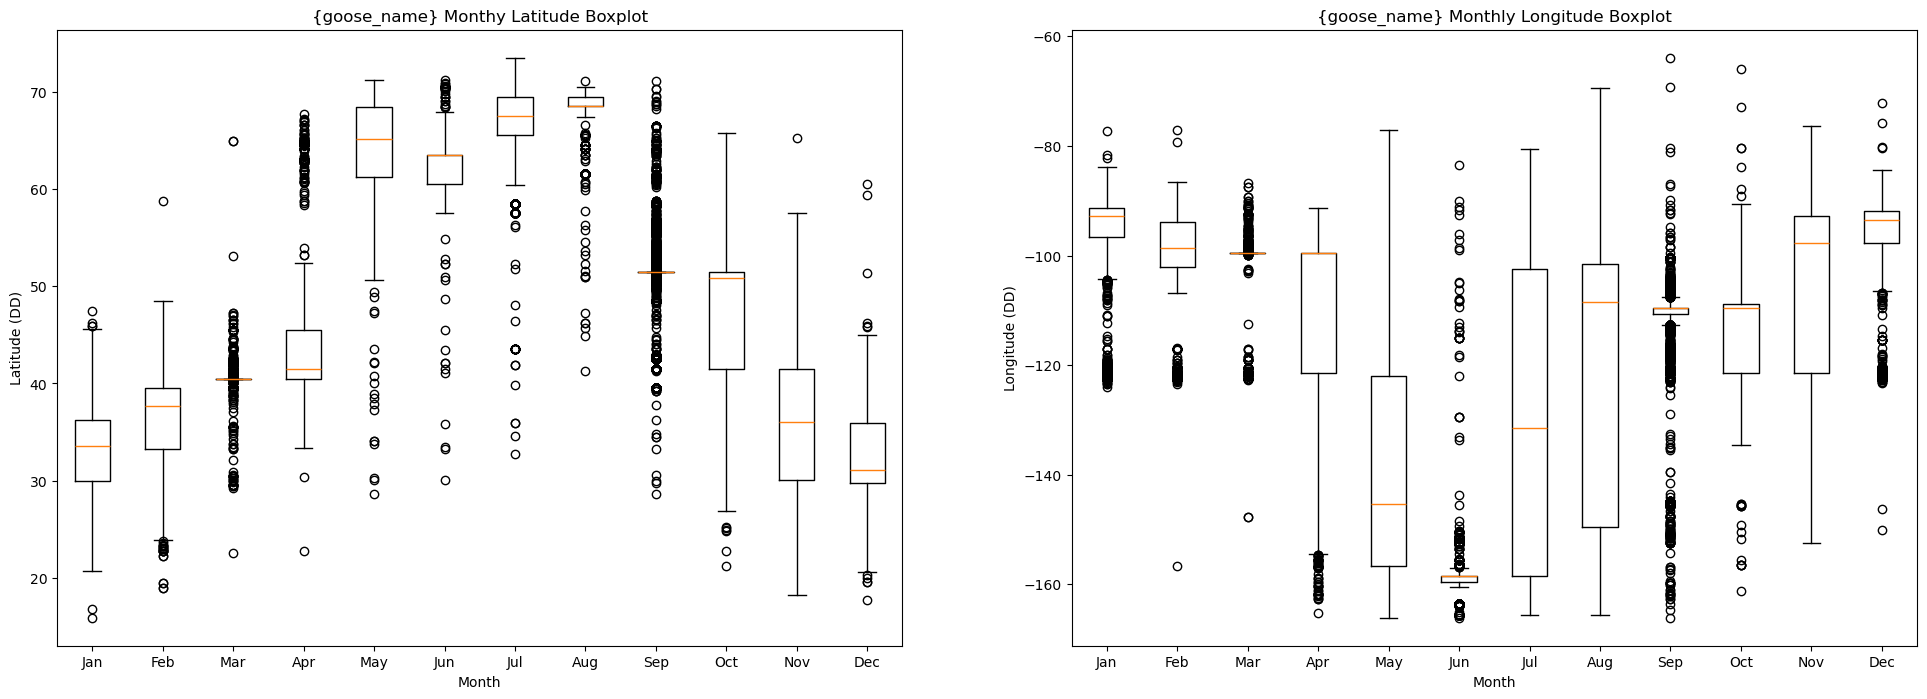

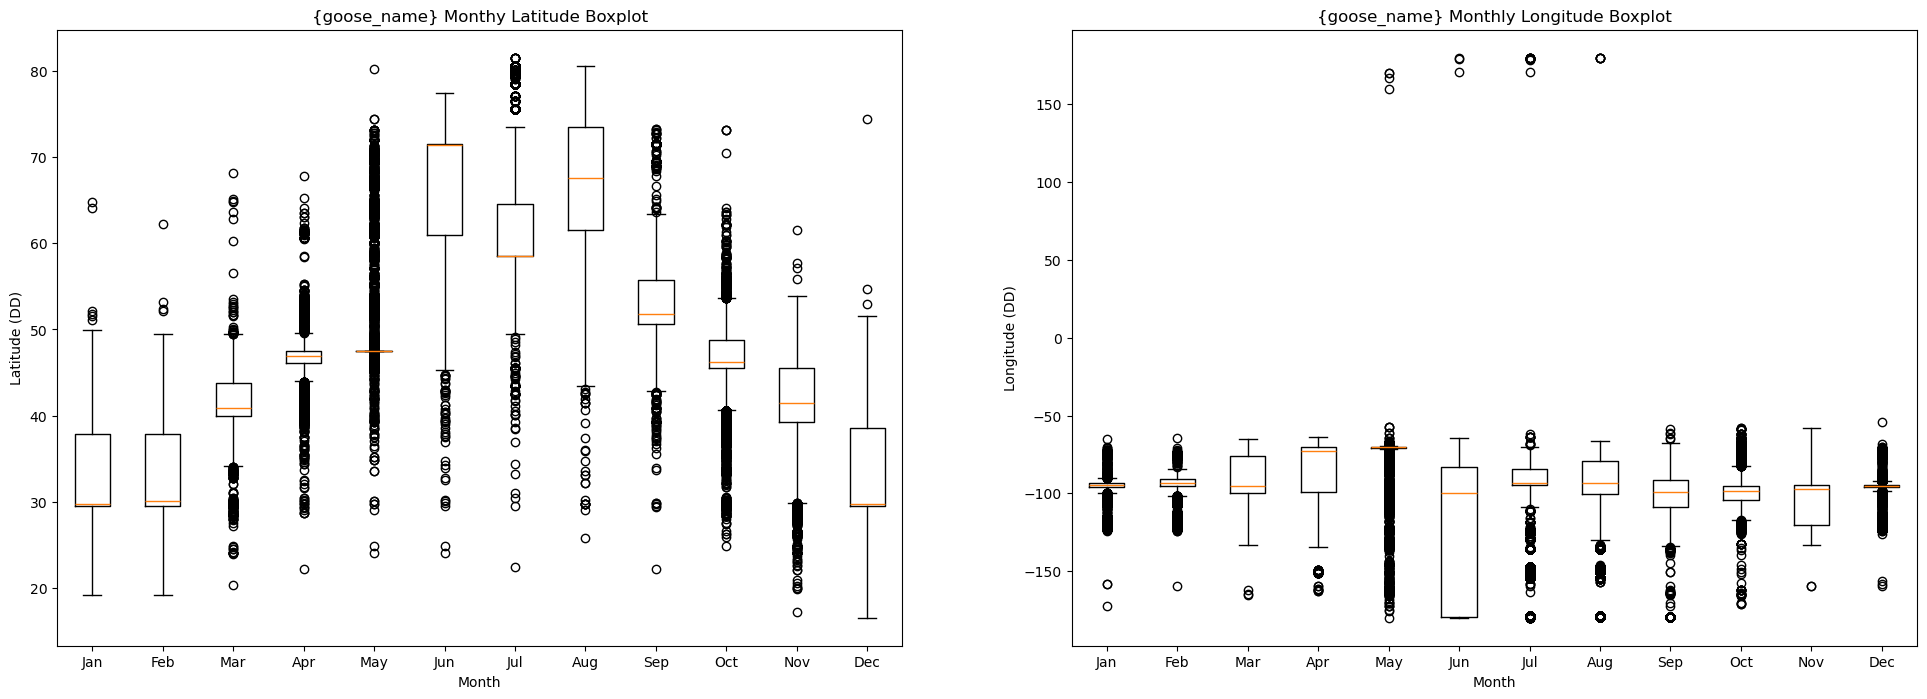

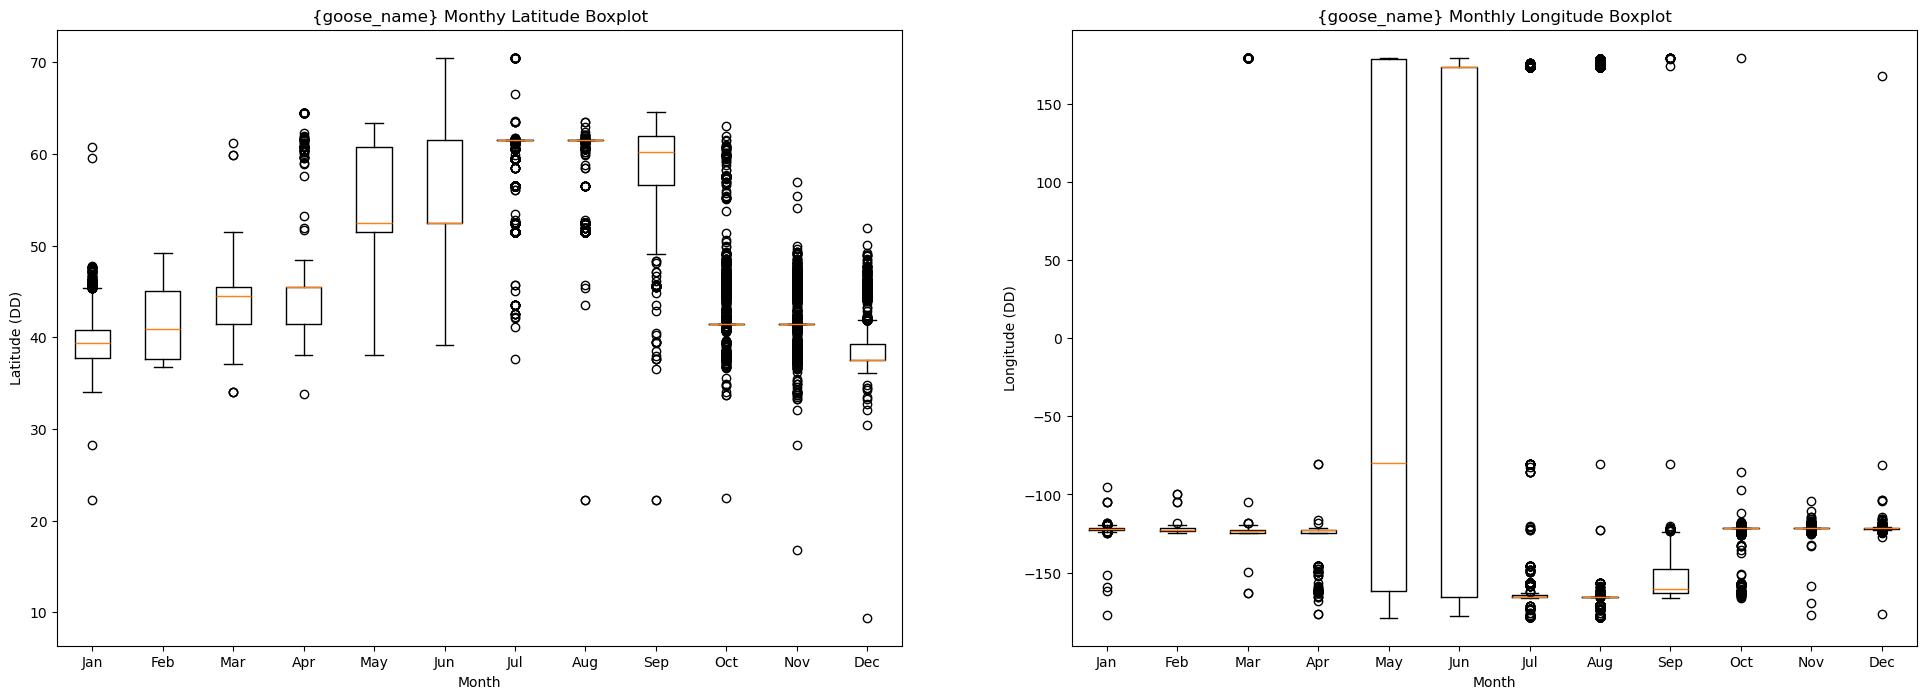

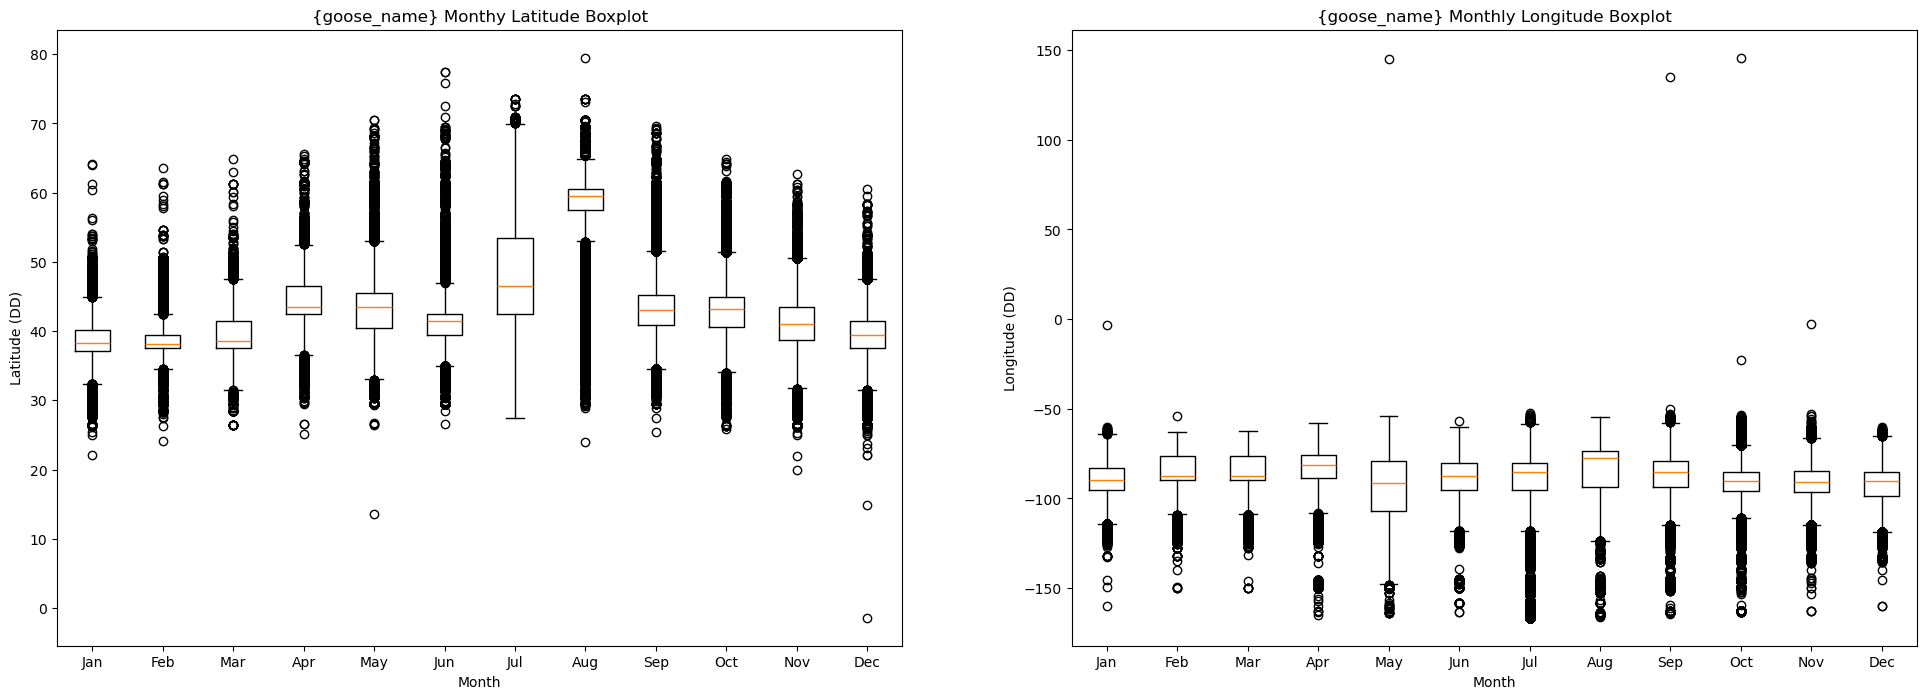

In [ ]:
#
# Make boxplots of the latitudes and longitudes by month
#

def make_boxplots(goose_data, lat_sample, lon_sample, goose_name = ''):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

    ax1.boxplot(lat_sample)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Latitude (DD)')
    ax1.set_xticklabels(months)
    ax1.set_title(f"{goose_name} Monthy Latitude Boxplot")

    ax2.boxplot(lon_sample)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Longitude (DD)')
    ax2.set_xticklabels(months)
    ax2.set_title(f"{goose_name} Monthly Longitude Boxplot")

    plt.show()

make_boxplots(white_fronted_goose_data, white_fronted_goose_lat_sample, white_fronted_goose_lon_sample, 'White Fronted Goose')
make_boxplots(snow_goose_data, snow_goose_lat_sample, snow_goose_lon_sample, 'Snow Goose')
make_boxplots(cackling_goose_data, cackling_goose_lat_sample, cackling_goose_lon_sample, 'Cackling Goose')
make_boxplots(canada_goose_data, canada_goose_lat_sample, canada_goose_lon_sample, 'Canada Goose')

In [22]:
#
# Perform the Mood's Median test on latitude and longitude data
#

def do_moods_median_test(lat_sample, lon_sample, goose_name = ''):
    # Perform the Mood's Median test on latitude and longitude data and thank scipy for not making me do it manually
    lat_p_value = stats.median_test(*lat_sample).pvalue
    lon_p_value = stats.median_test(*lon_sample).pvalue

    # Print out the results
    print(f"Mood's Median test on {goose_name} for lattitude p-value: {lat_p_value}")
    print(f"Mood's Median test on {goose_name} for longitude p-value: {lon_p_value}")

do_moods_median_test(white_fronted_goose_lat_sample, white_fronted_goose_lon_sample, 'White Fronted Goose')
do_moods_median_test(snow_goose_lat_sample, snow_goose_lon_sample, 'Snow Goose')
do_moods_median_test(cackling_goose_lat_sample, cackling_goose_lon_sample, 'Cackling Goose')
do_moods_median_test(canada_goose_lat_sample, canada_goose_lon_sample, 'Canada Goose')

Mood's Median test on White Fronted Goose for lattitude p-value: 0.0
Mood's Median test on White Fronted Goose for longitude p-value: 0.0
Mood's Median test on Snow Goose for lattitude p-value: 0.0
Mood's Median test on Snow Goose for longitude p-value: 0.0
Mood's Median test on Cackling Goose for lattitude p-value: 0.0
Mood's Median test on Cackling Goose for longitude p-value: 0.0
Mood's Median test on Canada Goose for lattitude p-value: 0.0
Mood's Median test on Canada Goose for longitude p-value: 0.0


In [23]:
def post_hoc_mood(months_dict, goose_name = ''):
    #
    # Perform the Mann-Whitney U test for each pair of months
    #

    # Initialize a 12x12 matrix to store the results of the Mann-Whitney U test
    mann_whitney_results = np.full((12, 12), None, dtype=object)

    # Perform the Mann-Whitney U test for each relevant pair of months
    for i in range(0, 12):
        for j in range(i + 1, 12):
            lat_stat, lat_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LAT_DD'], months_dict.get_group(j + 1)['LAT_DD'], alternative='two-sided')
            lon_stat, lon_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LON_DD'], months_dict.get_group(j + 1)['LON_DD'], alternative='two-sided')
            mann_whitney_results[i][j] = (lat_stat, lat_p_value, lon_stat, lon_p_value)

    # Store the results into a DataFrame for better visualization
    mann_whitney_df = pd.DataFrame(mann_whitney_results, index=range(1, 13), columns=range(1, 13))

    # Extract the relevant statistics and p-values from the DataFrame
    mw_lat_stat_df = mann_whitney_df.map(lambda x: x[0] if x is not None else None)
    mw_lat_p_df = mann_whitney_df.map(lambda x: x[1] if x is not None else None)
    mw_lon_stat_df = mann_whitney_df.map(lambda x: x[2] if x is not None else None)
    mw_lon_p_df = mann_whitney_df.map(lambda x: x[3] if x is not None else None)

    # Table whose values correspond to whether the null hypothesis can be rejected for each pair of months
    mw_lat_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 if x is not None else None)
    mw_lon_h0_reject_df = mann_whitney_df.map(lambda x: x[3] < 0.05 if x is not None else None)
    mw_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 and x[3] < 0.05 if x is not None else None)

    print(f'Post-hoc for {goose_name}')
    # Display the results
    #     True  -> Reject Null
    #     False -> Fail to Reject
    #      None -> Not Tested
    display(mw_h0_reject_df)

post_hoc_mood(white_fronted_goose_months_dict, 'White Fronted Goose')
post_hoc_mood(snow_goose_months_dict, 'Snow Goose') 
post_hoc_mood(cackling_goose_months_dict, 'Cackling Goose')
post_hoc_mood(canada_goose_months_dict, 'Canada Goose')

Post-hoc for White Fronted Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,True
2,None,None,True,True,True,True,True,True,True,True,False,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,True,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,False,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


Post-hoc for Snow Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,False
2,None,None,True,True,True,True,True,True,True,True,True,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,True,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,False,True


Post-hoc for Cackling Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,False,True,True,True,True,True,True,True
2,None,None,True,True,False,False,True,True,True,False,True,True
3,None,None,None,True,False,False,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,False,False,False
6,None,None,None,None,None,None,True,True,False,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


Post-hoc for Canada Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,True
2,None,None,True,True,True,True,True,True,True,True,True,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,False,True,True,True,True
5,None,None,None,None,None,True,True,True,False,False,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True
